#### Here we are merging the two comments collection to eliminate the duplicated video_id along with coverting it into a csv for further processing

In [2]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["ted"]
db.list_collection_names()

['ted_stats_new',
 'all_comments_old',
 'ted_stats',
 'ted_comments_new',
 'merged_comment',
 'ted_transcript_new',
 'ted_comments_old',
 'ted_transcript_old']

In [3]:
from pymongo import MongoClient
from pymongo.errors import ServerSelectionTimeoutError

try:
    client = MongoClient("mongodb://localhost:27017/", serverSelectionTimeoutMS=5000)
    client.server_info()  # Will throw if MongoDB is not reachable
    print("MongoDB is running!")
except ServerSelectionTimeoutError as err:
    print("Could not connect to MongoDB:", err)


MongoDB is running!


#### Created new collection to store the merged output and initilized old and new comment data

In [ ]:
old_col = db.get_collection("ted_comments_old")
new_col = db.get_collection("ted_comments_new")
db.create_collection("all_comments_old")
existing_video_ids = set()
merged_col=db.get_collection("all_comments_old")

#### Storing the unique values in a new collectio now...

In [ ]:
existing_video_ids = set()
old_docs = list(old_col.find({}))

for doc in old_docs:
    for item in doc.get("items", []):
        snippet = item.get("snippet", {})
        video_id = snippet.get("videoId")
        if video_id:
            existing_video_ids.add(video_id)

merged_col.insert_many(old_docs)
print(f"✅ Inserted {len(old_docs)} old documents")
print(f"🎥 Collected {len(existing_video_ids)} unique videoIds from old comments")

inserted_count = 0
skipped_count = 0

for doc in new_col.find({}):
    new_video_ids = set()
    for item in doc.get("items", []):
        snippet = item.get("snippet", {})
        video_id = snippet.get("videoId")
        if video_id:
            new_video_ids.add(video_id)

    print(f"🔍 Checking new doc with videoIds: {new_video_ids}")

    if not new_video_ids.isdisjoint(existing_video_ids):
        skipped_count += 1
        print("⛔ Skipping this doc — videoId already exists")
        continue

    merged_col.insert_one(doc)
    existing_video_ids.update(new_video_ids)
    inserted_count += 1
    print("✅ Inserted new doc")

print(f"📝 Final merge: {inserted_count} new documents inserted, {skipped_count} skipped.")

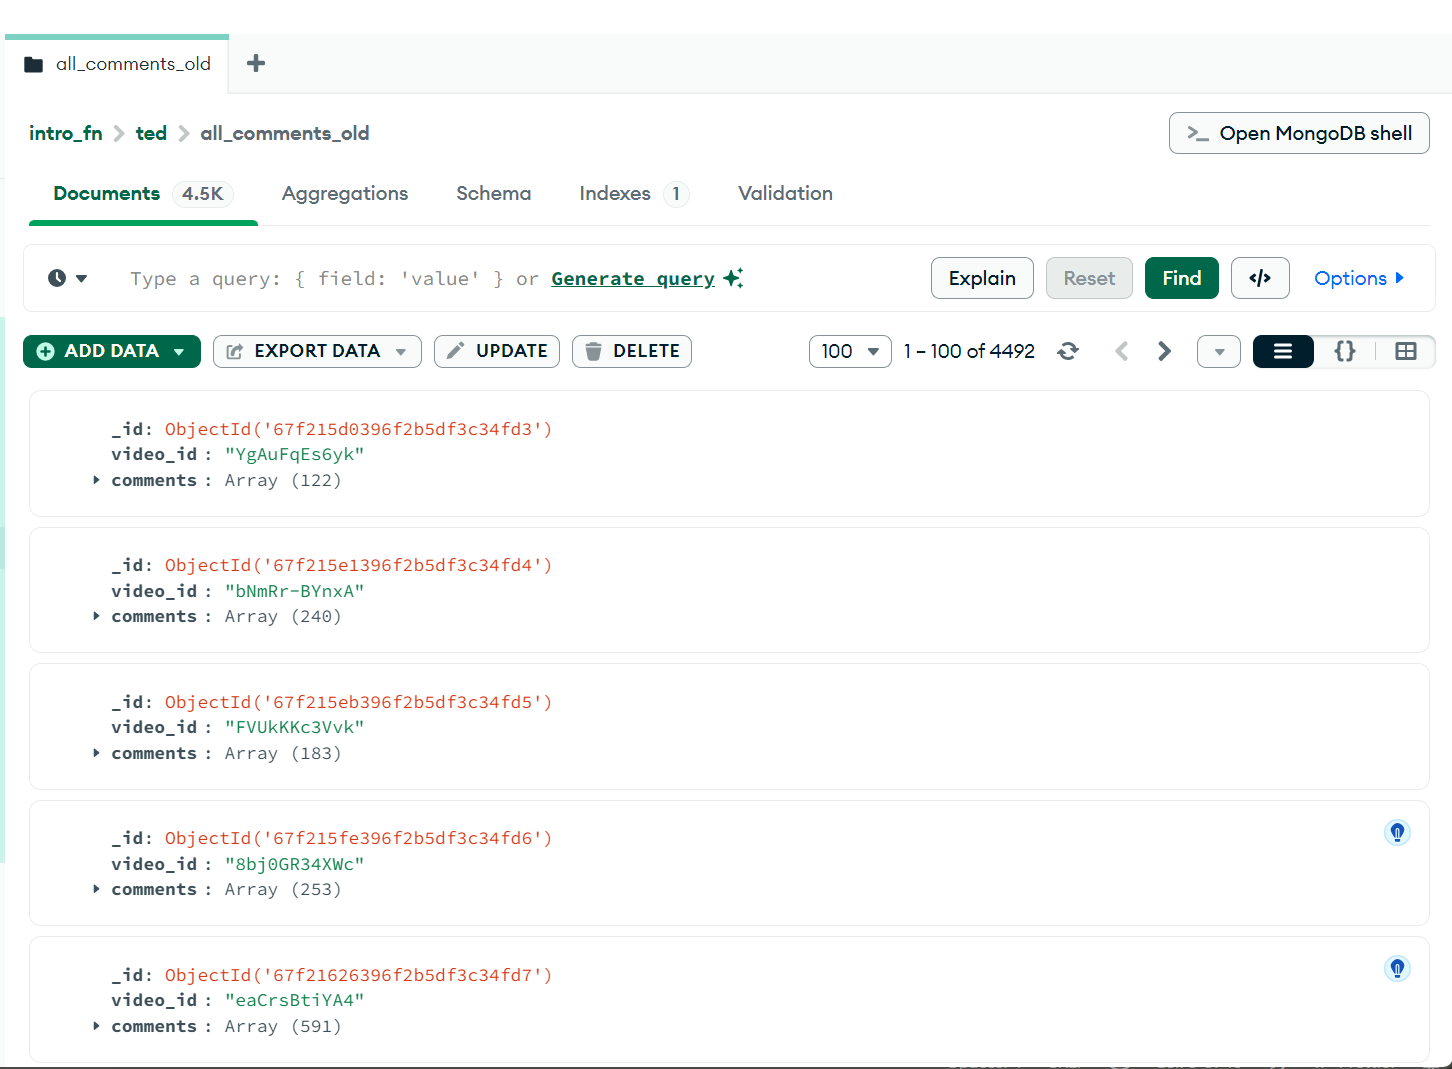
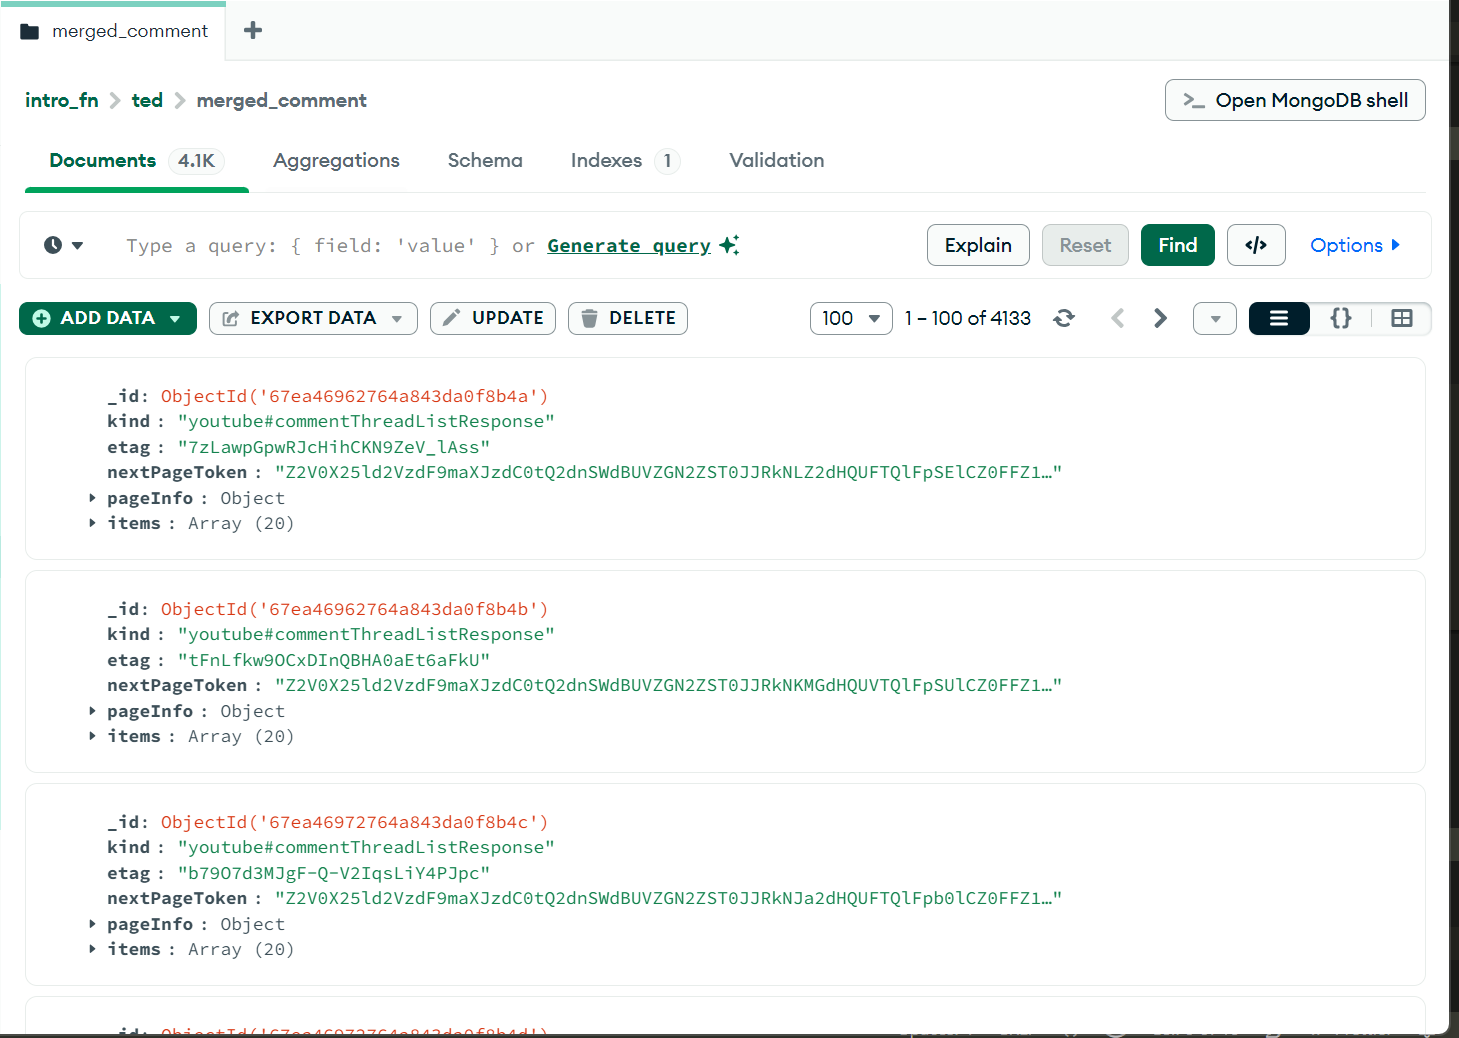

### getting one file to store all the new and old links

In [ ]:
import pickle


with open("E:\\NLP_Recommender_System\\scraping\\random_processes\\scraped_links_2025.pkl", "rb") as f:
    old_ids = pickle.load(f)

with open("E:\\NLP_Recommender_System\\data\\ted_video_links_2730.pkl", "rb") as f:
    new_ids = pickle.load(f)


old_set = set(old_ids)
merged_ids = list(old_set)
skipped_ids = []

for vid in new_ids:
    if vid not in old_set:
        merged_ids.append(vid)
        old_set.add(vid)
    else:
        skipped_ids.append(vid)


with open("merged_video_ids.pkl", "wb") as f:
    pickle.dump(merged_ids, f)


with open("skipped_video_ids.txt", "w") as f:
    for vid in skipped_ids:
        f.write(vid + "\n")

print(f"✅ Merged: {len(merged_ids)} unique video IDs")
print(f"⛔ Skipped: {len(skipped_ids)} duplicate video IDs (logged in skipped_video_ids.txt)")

✅ Merged: 4565 unique video IDs
⛔ Skipped: 1377 duplicate video IDs (logged in skipped_video_ids.txt)


In [7]:
with open("E:\\NLP_Recommender_System\\data\\comments.pkl" , "rb" ) as f:
    previous_comment_data=pickle.load(f)

In [30]:
previous_comment_data.shape

(5492, 2)

In [4]:
ted_comments = db.get_collection("all_comments_old")

#### Creating a dataframe now from our Mongodb Collection

In [ ]:
import pandas as pd

data = []

for doc in ted_comments.find():
    video_id = doc.get("video_id")
    comments = doc.get("comments", [])

    comment_texts = [c.get("text", "").strip() for c in comments if c.get("text")]
    joined_comments = "_ ".join(comment_texts)

    data.append({
        "video_id": video_id,
        "all_comments": joined_comments
    })

df_comments = pd.DataFrame(data)

df_comments.to_csv("video_comments.csv", index=False)

#### SO this is what the comment looks like....

In [13]:
comments_array=df_comments.head(1).values[0]
comments_array

array(['YgAuFqEs6yk',
       'Amazing_ This is true. Sometimes things happen that arent positive but out of every negative thing that happens there is a seed of opportunity for growth and change. I am happy these people were able to put their differences aside and were able to do what\'s best for the child. I am going through something similar however i don\'t want to be enemies with the mother of my children. I will always love her and respect her for everything she gave me._ Powerful & Amazing_ I can’t take a guy with dreads and a Detroit hat on on a ted talk seriously at all sorry 👎👎👎_ How They Both Move Close To Each-other As They Talk 🥺_ Now these are 2 beautiful grown black adults...not Cardi B and Offset lol_ Thank you._ I think it\'s so wonderful how they are speaking to an audience but really to each other. So it\'s genuine. And it makes their message so relatable_ Parents need to watch this._ Two min in and I’m wishing all women would think this way. 50 50 parenting support..

#### Just making sure all our file is as expected

In [ ]:
import pandas as pd
w= pd.read_csv("E:\\NLP_Recommender_System\\merge_comments\\video_comments.csv")

In [13]:
new=w.tail(1).values
new[0]

array(['PX61e3sAj5k&pp=0gcJCb8Ag7Wk3p_U',
       ',🌈🫰_ Very nice Thanks 🙏🙏_ Thank you excellent video!!!_ That\'s very motivational.  Thank you❤_ Класс!.. Круто!..ведь это действительно так!.. Благодарю Тина! 💖💞🙏😂_ ♥️🙏👌_ Спасибо Вам большое. Очень интересно. Хочу применить в своей жизни._ Imagine doing this for an English assignment😢_ A very fascinating talk which bring new perspective of luck for me. Thanks Tina. Love from Indonesia_ I\'ve searched her here because I was so curioused to know who was this incredible author of one of my favorite book entitled "What I wish I knew when I was 20". It\'s so beautiful filled with wisdom and advices to take some risks in order to succeed. Muchísimas gracias por el conocimiento 🤍🤍_ Благодарю вас ❤❤❤_ Благодарю , прослушала на одном дыхании ._ Thank you so much for the great report, invaluable tips!❤❤❤_ 🙏🙏🙏💖🤗🥰❤️_ Inspirational video ❤👍_ Благодарю Вас!!!❤❤❤🌹🌹🌹🥰_ Terrible, she is describing networking not lick._ Send out thank you notes!_ You can

#### seeing a comment in a text file to familiarized with the data in one video

In [21]:
import numpy as np
# Example array
# Extract values from array
video_id, comments_text = new[0]
# Save to text file
with open("first_video.txt", "w", encoding="utf-8") as f:
    f.write(f"Video ID: {video_id}\n\n")
    f.write(comments_text)

### final output , a csv

In [14]:
w

video_id  \
0                         YgAuFqEs6yk   
1                         bNmRr-BYnxA   
2                         FVUkKKc3Vvk   
3                         8bj0GR34XWc   
4                         eaCrsBtiYA4   
...                               ...   
4487                      WZWRhLW7Y8w   
4488                      VxGMqKCcN6A   
4489                      SixQ6cTzYaI   
4490                      9TFi9Zo4FJc   
4491  PX61e3sAj5k&pp=0gcJCb8Ag7Wk3p_U   

                                           all_comments  
0     Amazing_ This is true. Sometimes things happen...  
1     Bravo!_ A successful mindset isn't something t...  
2     I enjoyed😊 her book, My Side of the River._ So...  
3     I completely believe that this guy's name is n...  
4     I am a minister and the more I read scriptures...  
...                                                 ...  
4487  It's out in the open a new word to describe a ...  
4488  : I have a ‘serious’ (word salad) question for...  
4489  Deep amazing message._ I am a syrian and i hop...  
4490  Six minutes and twenty three seconds of word s...  
4491  ,🌈🫰_ Very nice Thanks 🙏🙏_ Thank you excellent ...  

[4492 rows x 2 columns]